## **Перцептрон с нуля на NumPy**
### **make_moons и make_circles**
Это генераторы синтетических наборов данных для задач классификации. Они создают двумерные точки с двумя классами, расположенными в виде:

- **make_moons:** два набора точек, образующих две пересекающиеся дуги окружностей (формы полумесяцев) - ответ класс своей дуги.
- **make_circles:** концентрических окружностей, две окружности с общим центром (один класс внутри, другой снаружи) - ответ класс внешний или внутрений круг.

Оба набора **не являются линейно разделимыми**, поэтому их часто используют для демонстрации работы нелинейных алгоритмов. Функции возвращают матрицу признаков X и вектор меток(ответов) y.

### **train_test_split**
Функция для разделения данных на обучающую и тестовую выборки.
Она принимает исходные данные (например, X и y) и случайным образом разбивает их на две части: одну для обучения модели, другую для проверки её качества.
### **StandardScaler**
Класс для стандартизации признаков. Он приводит данные к нулевому среднему и единичному стандартному отклонению (так называемое z-преобразование). Это важно для многих алгоритмов машинного обучения, которые чувствительны к масштабу признаков.

### Импорты

In [1]:
import numpy as np # для бысттрых матричных вычеслений

import matplotlib.pyplot as plt # Графики

from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Функции активации

In [2]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def relu(z: np.ndarray) -> np.ndarray:
    return np.maximum(0, z)

def sigmoid_grad(z: np.ndarray) -> np.ndarray:
    return (z) * (1 - sigmoid(z))

def relu_grad(z: np.ndarray) -> np.ndarray:
    return (z > 0).astype(float)

## **MLP с нуля**

In [3]:
class MLP:
    def __init__(self, layer_sizes: list[int], activation: str = 'relu', lr: float = 0.01):

        self.lr = lr
        self.activation, self.activation_grad = (relu, relu_grad) if activation == 'relu' else (sigmoid, sigmoid_grad)
        self.weights = []
        self.biases = []

        for fan_in, fan_out in zip(layer_sizes[:-1], layer_sizes[1:]):

            # np.sqrt(2 / fan_in) масштабируем веса так, чтобы дисперсия активаций оставалась
            # стабильной на всех слоях независимо от их размера.
            W = np.random.randn(fan_in, fan_out) * np.sqrt(2 / fan_in)
            b = np.zeros((1, fan_out))

            self.weights.append(W)
            self.biases.append(b)


    def forward(self, X: np.array) -> np.ndarray:
        self.linear_outputs = []
        self.activations = [X]

        last_layer = len(self.weights) - 1

        for i, (W, b) in enumerate(zip(self.weights, self.biases)):

            z = self.activations[-1] @ W + b
            self.linear_outputs.append(z)

            a = sigmoid(z) if i == last_layer else self.activation(z)
            self.activations.append(a)

        return self.activations[-1]


    def compute_loss(self, y_pred: np.array, y_true: np.array) -> float:
        eps = 1e-8
        y_pred = y_pred.flatten()
        return -np.mean(y_true * np.log(y_pred + eps) +
                        (1 - y_true) * np.log(1 - y_pred + eps))


    def backward(self, y_true: np.array):
        m = y_true.shape[0]                                # размер батча
        dA = self.activations[-1] - y_true.reshape(-1, 1)

        grads_W = [None] * len(self.weights)
        grads_b = [None] * len(self.biases)

        for i in range(len(self.weights) - 1, -1, -1):
            dW = self.activations[i].T @ dA / m
            db = np.mean(dA, axis=0, keepdims=True)

            grads_W[i] = dW
            grads_b[i] = db

            if i > 0:
                dA = (dA @ self.weights[i].T) * self.activation_grad(self.linear_outputs[i-1])

        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * grads_W[i]
            self.biases[i]  -= self.lr * grads_b[i]


    def fit(self, X: np.array, y: np.array, epochs: int = 1000, verbose: bool = True) -> list[float]:
        losses = []

        for epoch in range(epochs):

            y_pred = self.forward(X)
            loss = self.compute_loss(y_pred, y)

            self.backward(y)
            losses.append(loss)

            if verbose and epoch % 200 == 0:
                acc = np.mean((y_pred.flatten() > 0.5) == y)
                print(f"Epoch {epoch:4d} | Loss: {loss:.4f} | Acc: {acc:.3f}")

        return losses

    def predict(self, X: np.array) -> np.ndarray:
        return (self.forward(X).flatten() > 0.5).astype(int)

### Эксперимент: XOR проблема

In [4]:
print("=" * 46)
print("Эксперимент 1: XOR линейно неразделимая задача")
print("=" * 46)

X_xor = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y_xor = np.array([0, 1, 1, 0], dtype=float)

# Перцептрон (1 слой): не справиться
single = MLP([2, 1], lr=0.1)
losses_single = single.fit(X_xor, y_xor, epochs=1000, verbose=False)
print(f"Perceptron (1 layer) final acc: {np.mean(single.predict(X_xor) == y_xor):.2f}; должно быть 0.5-0.75")

# MLP (2+ слоев): справиться
mlp = MLP([2, 4, 1], lr=0.1)
losses_mlp = mlp.fit(X_xor, y_xor, epochs=1000, verbose=False)
print(f"MLP (2 layers)  final acc: {np.mean(mlp.predict(X_xor) == y_xor):.2f}; должно быть 1.0")

Эксперимент 1: XOR линейно неразделимая задача
Perceptron (1 layer) final acc: 0.50; должно быть 0.5-0.75
MLP (2 layers)  final acc: 0.75; должно быть 1.0


### Эксперимент 2: Реальные данные (make_moons)

In [5]:
print("=" * 46)
print("Эксперимент 2: Нелинейная граница (make_moons)")
print("=" * 46)

X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MLP([2, 16, 8, 1], lr=0.005)
losses = model.fit(X_train, y_train, epochs=3000)
test_acc = np.mean(model.predict(X_test) == y_test)
print(f"\nTest accuracy: {test_acc:.3f}")

Эксперимент 2: Нелинейная граница (make_moons)
Epoch    0 | Loss: 1.1099 | Acc: 0.258
Epoch  200 | Loss: 0.3437 | Acc: 0.840
Epoch  400 | Loss: 0.2967 | Acc: 0.845
Epoch  600 | Loss: 0.2831 | Acc: 0.855
Epoch  800 | Loss: 0.2765 | Acc: 0.865
Epoch 1000 | Loss: 0.2724 | Acc: 0.860
Epoch 1200 | Loss: 0.2691 | Acc: 0.860
Epoch 1400 | Loss: 0.2660 | Acc: 0.860
Epoch 1600 | Loss: 0.2632 | Acc: 0.860
Epoch 1800 | Loss: 0.2606 | Acc: 0.860
Epoch 2000 | Loss: 0.2580 | Acc: 0.863
Epoch 2200 | Loss: 0.2553 | Acc: 0.863
Epoch 2400 | Loss: 0.2525 | Acc: 0.868
Epoch 2600 | Loss: 0.2498 | Acc: 0.868
Epoch 2800 | Loss: 0.2472 | Acc: 0.868

Test accuracy: 0.860


### График данных

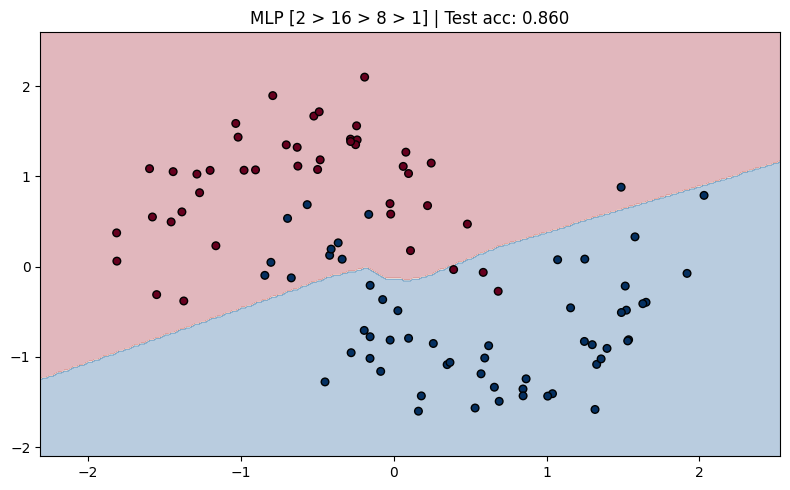

In [6]:
def plot_decision_boundary(model, X: np.ndarray, y: np.ndarray, title: str = "!"):

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    h = 0.02
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolors='k', s=30)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_decision_boundary(model, X_test, y_test,
                       title=f"MLP [2 > 16 > 8 > 1] | Test acc: {test_acc:.3f}")


## **То же самое на PyTorch**

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP_Torch(nn.Module):
    def __init__(self, layer_sizes: list[int], dropout: float = 0.0):
        super().__init__() # наследуемся
        layers = []

        for i in range(len(layer_sizes) - 2):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nn.ReLU())

            if dropout > 0:
                layers.append(nn.Dropout(dropout))

        layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x: np.ndarray) -> np.ndarray:
        return self.net(x)

# Данные в тензоры
X_tr = torch.FloatTensor(X_train)
y_tr = torch.FloatTensor(y_train)
X_te = torch.FloatTensor(X_test)
y_te = torch.FloatTensor(y_test)

# Модель, лосс и оптимизатор
model_torch = MLP_Torch([2, 32, 16, 1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_torch.parameters(), lr=1e-3)

### цикл обучения и теста

In [8]:
losses_torch = []

for epoch in range(1000):
    model_torch.train() # переводим в обучение

    optimizer.zero_grad()
    logits = model_torch(X_tr).squeeze()
    loss = criterion(logits, y_tr)
    loss.backward()
    optimizer.step()

    losses_torch.append(loss.item())

model_torch.eval() # переводим в тест

with torch.no_grad():
    logits_te = model_torch(X_te).squeeze()
    preds = (torch.sigmoid(logits_te) > 0.5).float()
    acc = (preds == y_te).float().mean()
    print(f"PyTorch MLP Test accuracy: {acc:.3f}")

PyTorch MLP Test accuracy: 0.990


### Сравнение кривых обучения

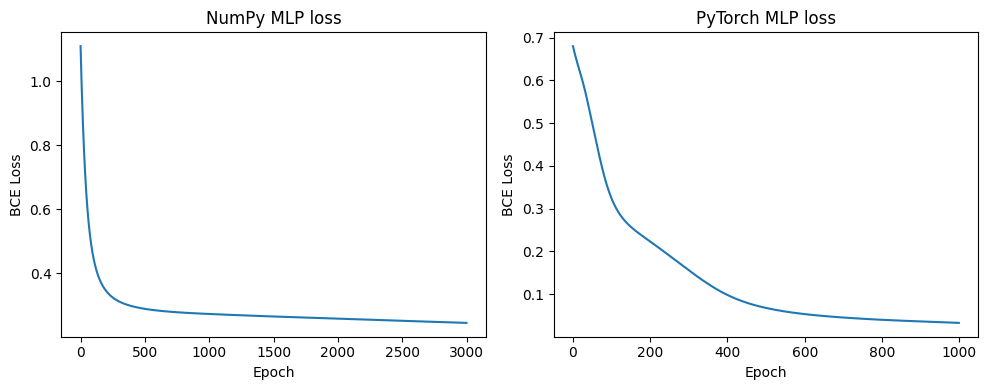

In [9]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("NumPy MLP loss")
plt.xlabel("Epoch"); plt.ylabel("BCE Loss")

plt.subplot(1, 2, 2)
plt.plot(losses_torch)
plt.title("PyTorch MLP loss")
plt.xlabel("Epoch"); plt.ylabel("BCE Loss")

plt.tight_layout()
plt.show()

## **Итоговая таблица: Активации**

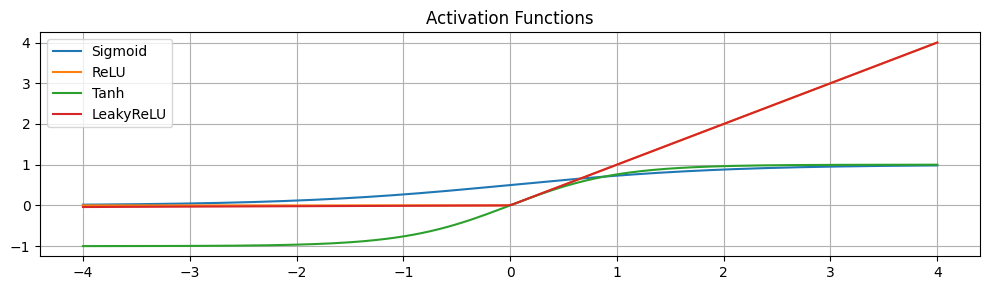

In [10]:
z = np.linspace(-4, 4, 200)
plt.figure(figsize=(10, 3))

for name, fn in [("Sigmoid", sigmoid), ("ReLU", relu),
                  ("Tanh", np.tanh), ("LeakyReLU", lambda z: np.where(z>0, z, 0.01*z))]:
    plt.plot(z, fn(z), label=name)

plt.legend(); plt.title("Activation Functions"); plt.grid(True)
plt.tight_layout(); plt.show()